<a href="https://colab.research.google.com/github/fundaylncii/FeatureEngineering/blob/main/DiabetesFeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin
edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli
geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını
gerçekleştirmeniz beklenmektedir**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics  import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier


pd.set_option("display.max_columns", None)
pd.set_option("display.max_row",None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [2]:
df_ = pd.read_csv("/content/diabetes.csv")
df = df_.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
## Genel Dataset İncelemesi Yapılır.
def dataset_info(dataset):
    print("Dataset Info")
    print("--------------------------------------")
    print(dataset.info())
    print("--------------------------------------")
    print("Dataset Describe")
    print("--------------------------------------")
    print(dataset.describe().T)
    print("--------------------------------------")
    print("Dataset Shape")
    print("--------------------------------------")
    print(dataset.shape)
    print("--------------------------------------")
    print("Dataset Isnull")
    print("--------------------------------------")
    print(dataset.isnull().sum())
    print("--------------------------------------")
    print("Dataset Duplicated")
    print("--------------------------------------")
    print(dataset.duplicated().sum())
    print("--------------------------------------")
    print("Dataset Columns")
    print("--------------------------------------")
    print(dataset.columns)
    print("--------------------------------------")

dataset_info(df)


Dataset Info
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
--------------------------------------
Dataset Describe
--------------------------------------
                           count    mean     std    min    25%     50%     75%     max
P

In [4]:
## Dataset içerisindeki numerik ve kategorik değişkenlerin tespit edilmesi.

def grap_col_names(dataframe, cat_th= 10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grap_col_names(df)
print(cat_cols)
print(num_cols)
print(cat_but_car)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
['Outcome']
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
[]


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
################################################################################


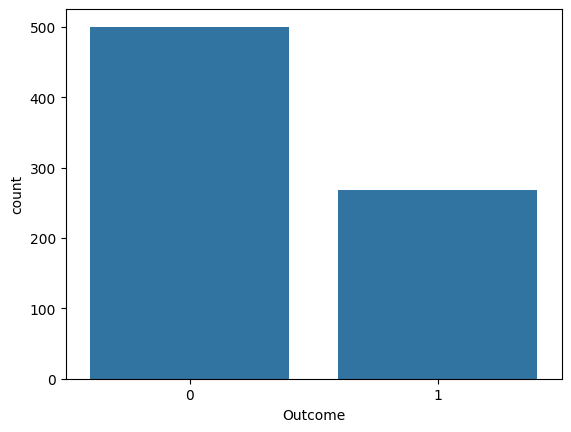

In [5]:
## Kategorik değişkenlerin analizi yapılır.

def cat_summary(dataframe, col_name, plot= False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("################################################################################")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show()

for col in cat_cols:
  cat_summary(df,col,True)

########## Pregnancies ##########
count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


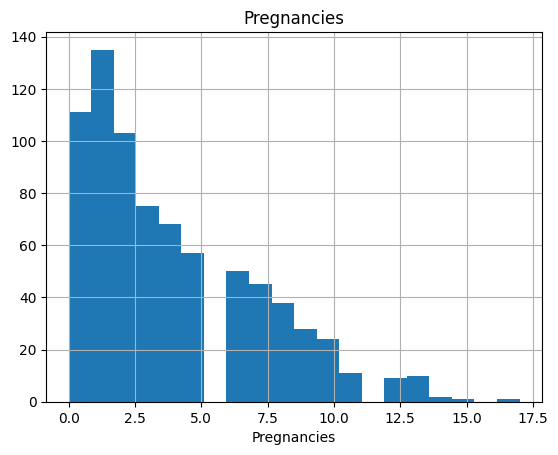

########## Glucose ##########
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


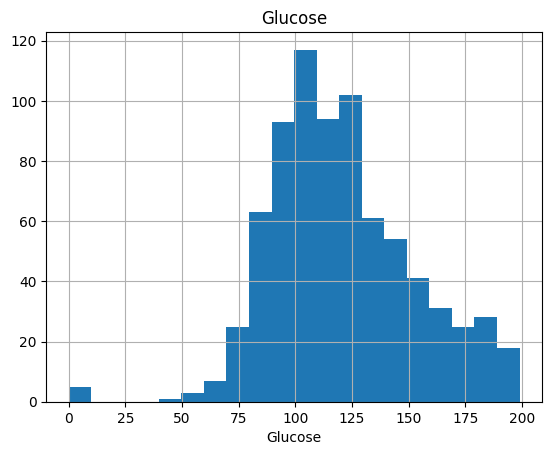

########## BloodPressure ##########
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


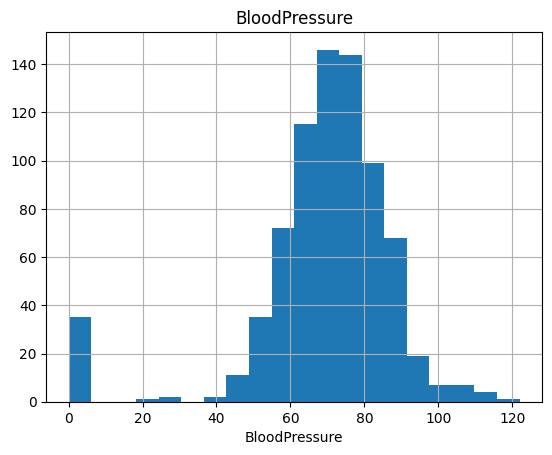

########## SkinThickness ##########
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


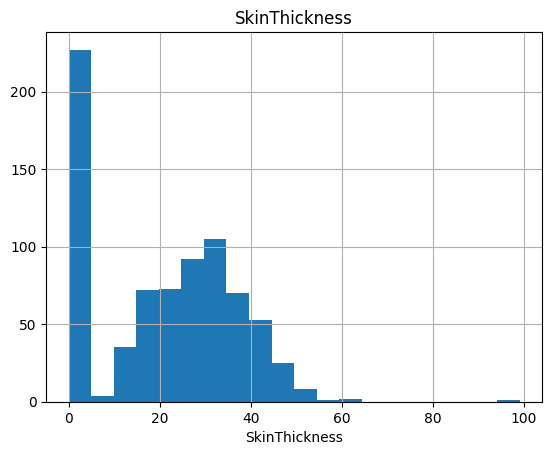

########## Insulin ##########
count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


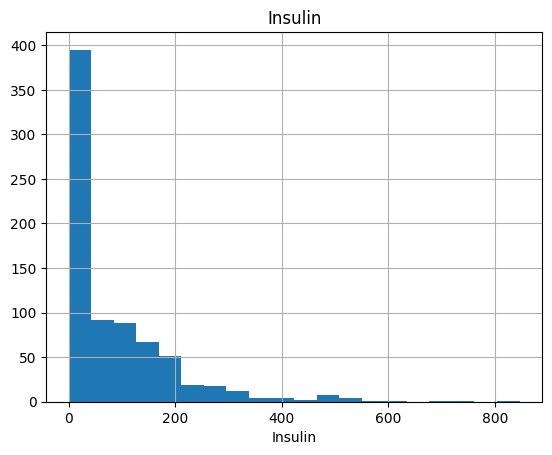

########## BMI ##########
count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


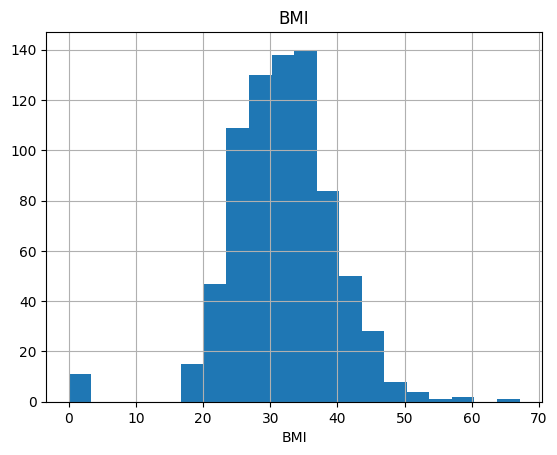

########## DiabetesPedigreeFunction ##########
count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


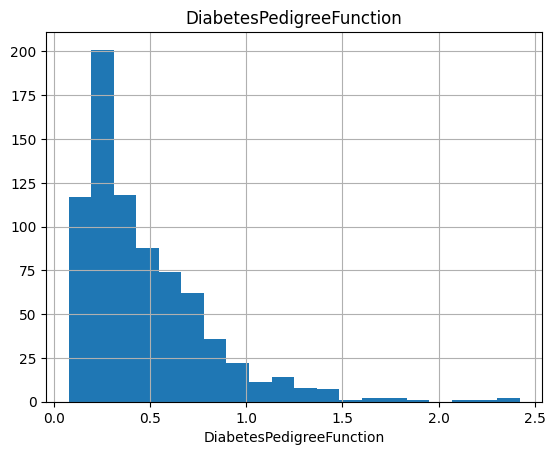

########## Age ##########
count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


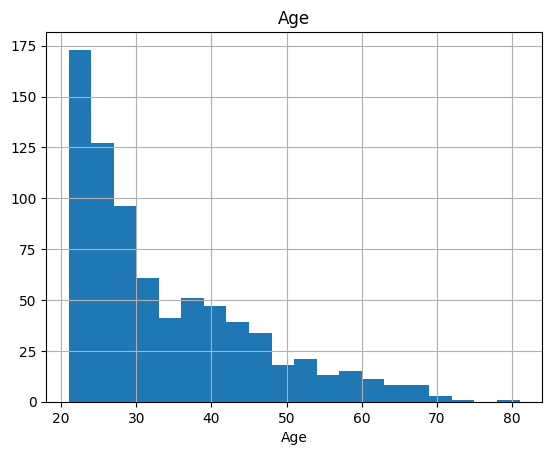

In [6]:
## Numerik değişkenlerin analizi yapılır.

def num_summary(dataframe, numerical_col, plot=False):
    print("##########",col,"##########")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
  num_summary(df,col,True)

In [7]:
## Hedef değişkene göre numerik değişkenlerin ortalamasının analiz edilmesi:

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
  target_summary_with_num(df,"Outcome",col)


         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




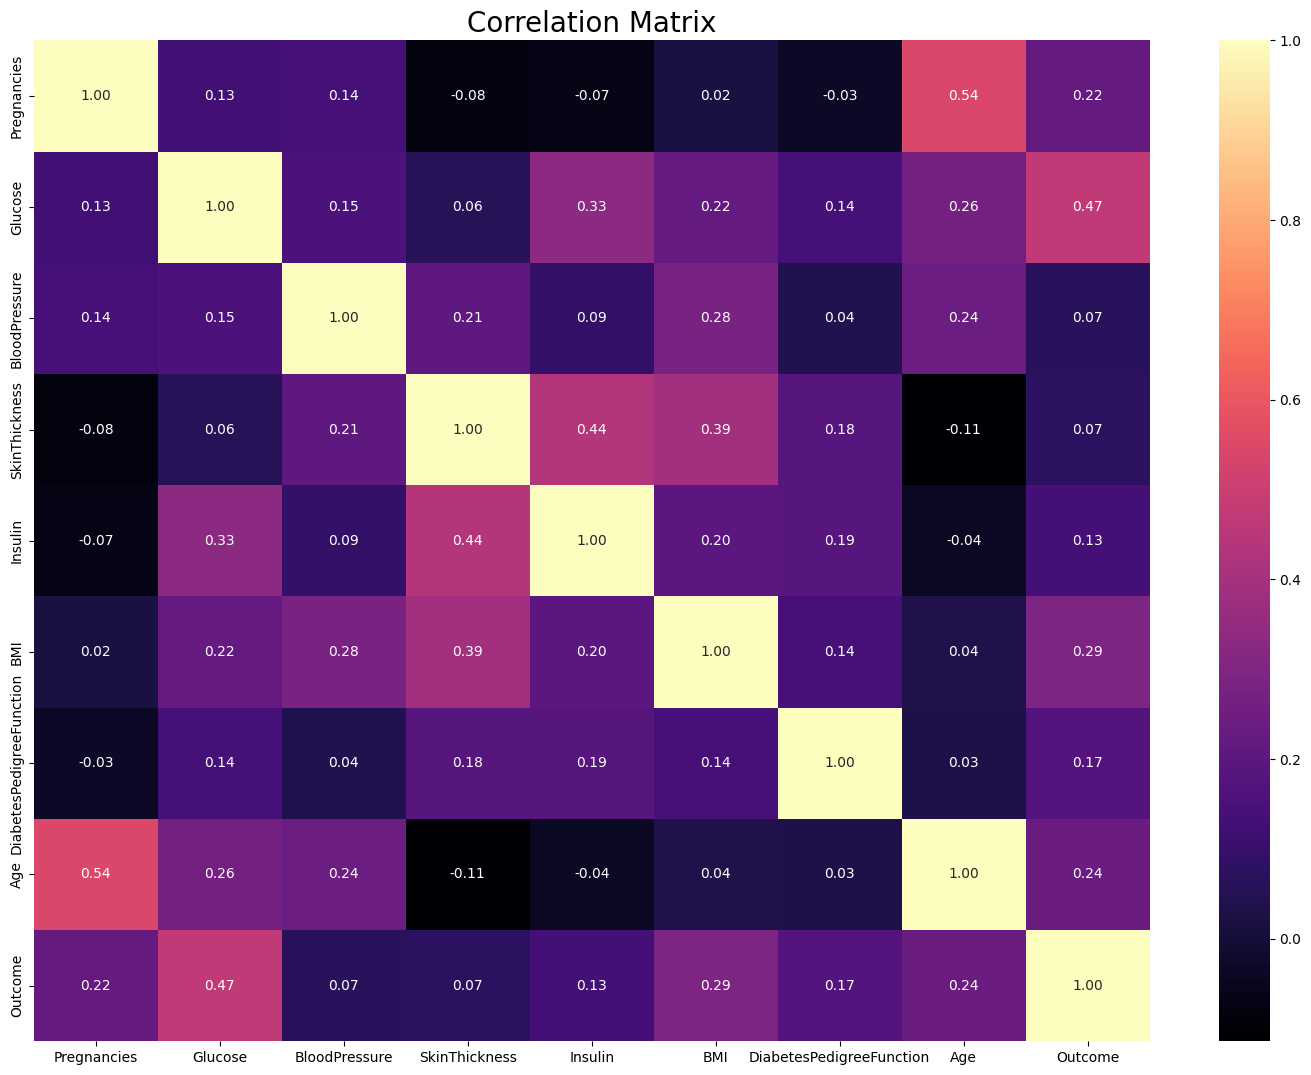

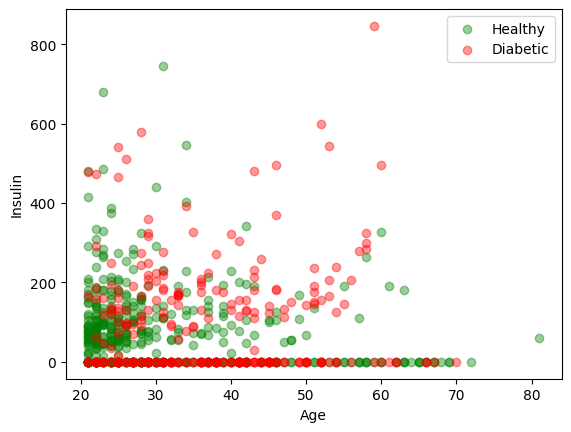

In [8]:
## korelasyon analizi yapılır.

df.corr()
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()
diabetic = df[df.Outcome == 1]
healthy = df[df.Outcome == 0]

plt.scatter(healthy.Age, healthy.Insulin, color="green", label="Healthy", alpha = 0.4)
plt.scatter(diabetic.Age, diabetic.Insulin, color="red", label="Diabetic", alpha = 0.4)
plt.xlabel("Age")
plt.ylabel("Insulin")
plt.legend()
plt.show()

In [9]:
## Base Modelin kurulması yapılır.
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


In [10]:
# Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
zero_columns = [ col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies","Outcome"])]
print(zero_columns)

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


In [11]:
# Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir .

for col in zero_columns:
  df[col] = df[col].replace(0, np.NaN)

In [12]:
## Eksik değerler var mı?

def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

na_columns = missing_values_table(df, True)
print(na_columns)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650
['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


In [13]:
for col in na_columns:
  df[col] = df[col].fillna(df[col].median())

In [14]:
## Eksik değerler tekrardan check edilir.
missing_values_table(df)

## OR

df.isnull().sum()

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
## Aykırı değer var mı ?

def outlier_threshold (dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit


def check_outlier(dataframe, col_name):
  low_limit , up_limit =  outlier_threshold(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

for col in df.columns:
  print(col,check_outlier(df,col))


Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Outcome False


In [16]:
## Aykırı değerler baskılanır.
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_threshold(dataframe, col_name)
  dataframe.loc[dataframe[col_name] < low_limit, col_name] = low_limit
  dataframe.loc[dataframe[col_name] > up_limit, col_name] = up_limit

for col in df.columns:
  replace_with_thresholds(df,col)

In [17]:
## Tekrardan aykırı değer var mı check edilir.

for col in df.columns:
  print(col,check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [18]:
## Yeni değişkenler türetilir.

## Yaş değişkeni segmentlere ayrılır

df["NEW_AGE_CAT"] = pd.qcut(df["Age"],3,labels=["Young","Middle-Aged","Senior"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1.000,Senior
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0.000,Middle-Aged
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1.000,Middle-Aged
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0.000,Young
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1.000,Middle-Aged


In [19]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df["NEW_BMI_CAT"] = pd.cut(x=df["BMI"], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight","Normal","Overweight","Obese"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI_CAT
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1.000,Senior,Obese
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0.000,Middle-Aged,Overweight
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1.000,Middle-Aged,Normal
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0.000,Young,Overweight
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1.000,Middle-Aged,Obese


In [20]:
## Kolon isimlerinin büyük harfe çevrilmesi yapılır.
df.columns = [col.upper() for col in df.columns]
print(df.columns)

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME', 'NEW_AGE_CAT', 'NEW_BMI_CAT'], dtype='object')


In [21]:
## Encoding işlemleri yapılır. Bu işlemde yeni değişkenler oluşturulduğu için tekrar grap_col_names uygulanır.

cat_cols, num_cols, cat_but_car = grap_col_names(df)
print(cat_cols)
print(num_cols)
print(cat_but_car)

Observations: 768
Variables: 11
cat_cols: 3
num_cols: 8
cat_but_car: 0
num_but_cat: 3
['OUTCOME', 'NEW_AGE_CAT', 'NEW_BMI_CAT']
['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE']
[]


In [26]:
## label encoding yapılarak binary değişkenlere encoding işlemi yapılır.
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1.000,Senior,Obese
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0.000,Middle-Aged,Overweight
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1.000,Middle-Aged,Normal
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0.000,Young,Overweight
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1.000,Middle-Aged,Obese


In [28]:
## one - hot encoding işlemi yapılır
## cat_cols içerisinden bağımlı değişken çıakrtılır.

cat_cols = [col for col in cat_cols if col not in ["OUTCOME"]]
print(cat_cols)

['NEW_AGE_CAT', 'NEW_BMI_CAT']


In [29]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_Middle-Aged,NEW_AGE_CAT_Senior,NEW_BMI_CAT_Normal,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Obese
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1.000,False,True,False,False,True
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0.000,True,False,False,True,False
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1.000,True,False,True,False,False
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0.000,False,False,False,True,False
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1.000,True,False,False,False,True


In [32]:
## dataset son haline standartlaştırma yapılır.

print(num_cols)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE']


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_Middle-Aged,NEW_AGE_CAT_Senior,NEW_BMI_CAT_Normal,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Obese
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1.000,False,True,False,False,True
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0.000,True,False,False,True,False
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1.000,True,False,True,False,False
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0.000,False,False,False,True,False
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1.000,True,False,False,False,True


In [33]:
## Model oluşturma:

y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.729
Precision: 0.63
F1: 0.68
Auc: 0.77


    Value                   Feature
1   0.248                   GLUCOSE
5   0.137                       BMI
7   0.135                       AGE
6   0.127  DIABETESPEDIGREEFUNCTION
2   0.082             BLOODPRESSURE
0   0.079               PREGNANCIES
3   0.067             SKINTHICKNESS
4   0.061                   INSULIN
12  0.019         NEW_BMI_CAT_Obese
9   0.014        NEW_AGE_CAT_Senior
8   0.013   NEW_AGE_CAT_Middle-Aged
10  0.010        NEW_BMI_CAT_Normal
11  0.010    NEW_BMI_CAT_Overweight


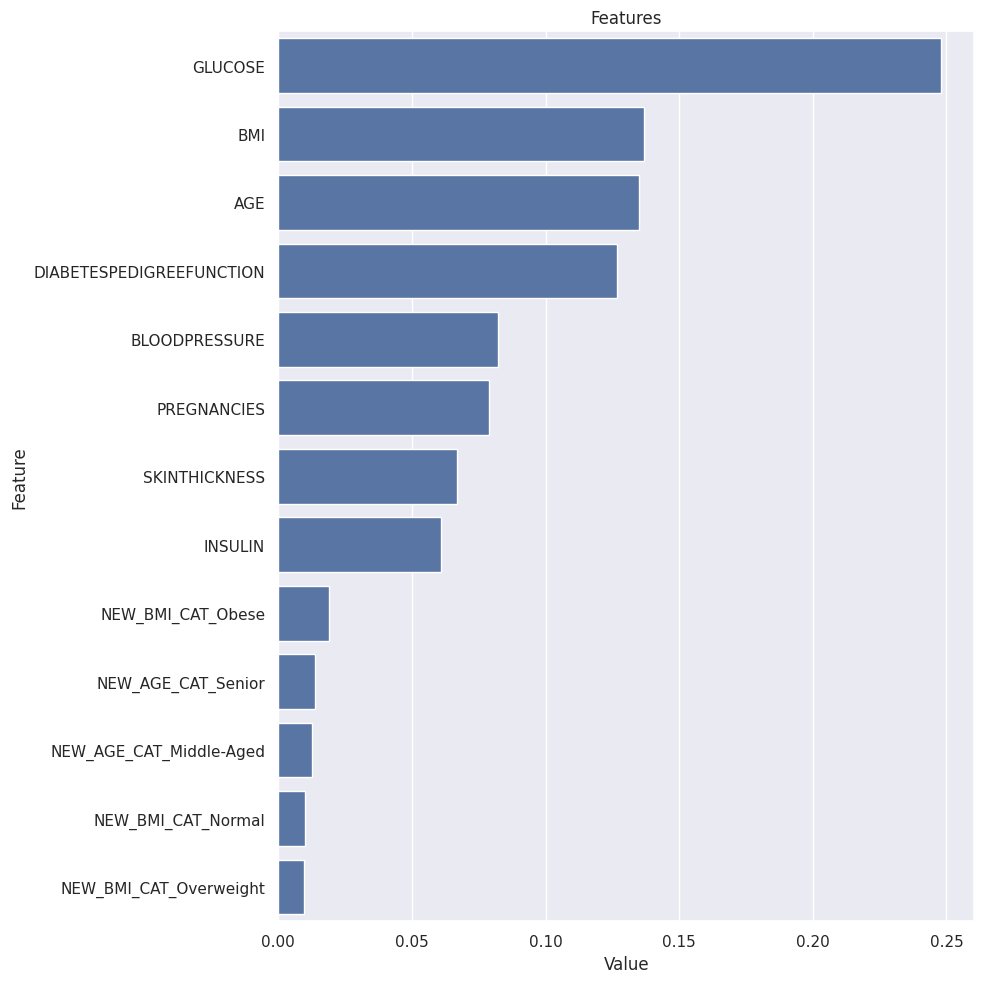

In [34]:
## Feature Importance

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)
